In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
from tabulate import tabulate
from fractions import Fraction
print("Imports Successful")

Imports Successful


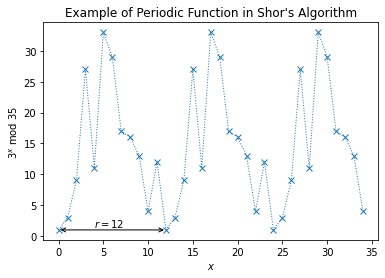

In [3]:
N = 35
a = 3

# プロットするデータを計算する, Prepare the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# matplotlibを使って描画, create the plots
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # グラフ上にrをプロット, plot the period on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')

Prepare an unitary operator to predict the phase of an state

$ U| y \rangle =|{\rm ay \;mod\; N\rangle} $

Uの固有状態がどのように見えるかを考えてみましょう。Lets consider the eigenstates of U


|1⟩の状態から開始した場合、Uが連続して適用され、つまり、レジスターの状態に 
a(modN) を乗算します。

このサイクルの重ね合わせ（ |u0⟩）は U の固有状態になります：

Let's thing the following superposed state:

$ |u_0\rangle = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} |a^r\;mod\;N\rangle$

TRIVIAL eigenvalue :(

Instead let's consider
    $ |u_1\rangle = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} e^{-2\pi i k/r}|a^r\;mod\;N\rangle$
    
Which satisfies

 $ U|u_1\rangle =  e^{2\pi i /r}|u_1\rangle$
 
 In general if we multiply by an integer s (0 < s < r−1 )the phase factor, we obtain the eigenstate
 
  $ U|u_s\rangle =  e^{2\pi i s/r}|u_s\rangle$
  
  Interesting property
  $ |1\rangle= \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1} |u_k\rangle$
  
  計算基底の状態 |1⟩
  がこれらの固有状態の重ね合わせである
 

Define the phase of the state $|u_s\rangle$ as $\phi= \frac{s}{r}$

連分数アルゴリズム(continued fraction algorithm) を使用して 
r
  を見つけます。1

EXAMPLE a=7, N=15

In [4]:
def c_amod15(a, power):
    """mod 15による制御ゲートをかける"""
    """ Apply a controlling gate by using mod15 residue"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U


In [6]:
# Specify variables
# let's use qbit 8 for measuring.
n_count = 8 # number of counting qubits
a = 7


In [7]:
# To get the phase lets use the inverse Fourier transform
def qft_dagger(n):
    """n量子ビットの逆QFTを回路の最初のn量子ビットにかける"""
    
    qc = QuantumCircuit(n)
    # Swapsを忘れない!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [8]:
# SHORS algorithm
# n_count個の測定用量子ビットとUを操作するための4量子ビットで, prepare qubits for measuring
# 量子回路を作る, create the circuit 
qc = QuantumCircuit(n_count + 4, n_count)

# 測定用量子ビットを
# |+>状態に初期化
# Apply Hadmart gate to the measuring qubits
for q in range(n_count):
    qc.h(q)
    
# アンシラレジスターを|1>の状態にする
# Let the state|1> be the ancilla state
qc.x(3+n_count)

# 制御Uを操作, apply the U gate
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# 逆QFTを操作, Inverse Fourier transform
qc.append(qft_dagger(n_count), range(n_count))

# 回路を測定
qc.measure(range(n_count), range(n_count))
qc.draw('text')

/tmp/ipykernel_20/3077976195.py:11: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(-np.pi/float(2**(j-m)), m, j)


┌───┐                                                            »
 q_0: ┤ H ├───────■────────────────────────────────────────────────────»
      ├───┤       │                                                    »
 q_1: ┤ H ├───────┼──────────────■─────────────────────────────────────»
      ├───┤       │              │                                     »
 q_2: ┤ H ├───────┼──────────────┼──────────────■──────────────────────»
      ├───┤       │              │              │                      »
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■───────»
      ├───┤       │              │              │              │       »
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      ├───┤       │              │              │              │       »
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼───────»
      └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐»
 q_8: ─────┤0            ├┤0            ├┤0            ├┤0            ├»
           │             ││             ││             ││             │»
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├»
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 │»
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├»
      ┌───┐│             ││             ││             ││             │»
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├»
      └───┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘»
 c: 8/═════════════════════════════════════════════════════════════════»
                                                                       »
«                                                                       »
« q_0: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_1: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_2: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_3: ─────────────────────────────────────────────────────────────────»
«                                                                       »
« q_4: ───────■─────────────────────────────────────────────────────────»
«             │                                                         »
« q_5: ───────┼───────────────■─────────────────────────────────────────»
«             │               │                                         »
« q_6: ───────┼───────────────┼───────────────■─────────────────────────»
«             │               │               │                         »
« q_7: ───────┼───────────────┼───────────────┼────────────────■────────»
«      ┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐»
« q_8: ┤0             ├┤0             ├┤0             ├┤0              ├»
«      │              ││              ││              ││               │»
« q_9: ┤1             ├┤1             ├┤1             ├┤1              ├»
«      │  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │»
«q_10: ┤2             ├┤2             ├┤2             ├┤2              ├»
«      │              ││              ││              ││               │»
«q_11: ┤3             ├┤3             ├┤3             ├┤3              ├»
«      └──────────────┘└──────────────┘└──────────────┘└───────────────┘»
« c: 8/═════════════════════════════════════════════════════════════════»
«                                                                       »
«      ┌───────┐┌─┐                  

Show results

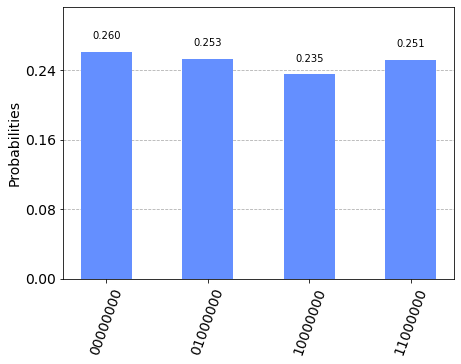

In [9]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

Get the phases from the results

In [10]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # 2進数を10進数に変換します
    phase = decimal/(2**n_count) # 固有値を探します
    measured_phases.append(phase)
    # これらの値をテーブルの行に追加します：
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# tabulateを使って、ASCIIテーブルとして行を印刷します：
print(tabulate(rows, 
               headers=["Register Output", "Phase"], 
               colalign=("left","right")))

Register Output                    Phase
------------------------  --------------
01000000(bin) = 64(dec)    64/256 = 0.25
11000000(bin) = 192(dec)  192/256 = 0.75
10000000(bin) = 128(dec)  128/256 = 0.50
00000000(bin) = 0(dec)      0/256 = 0.00
